# 0) Import all the necessary libraries

In [136]:
#Core numerical/data libraries
import pandas as pd
import numpy as np

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", rc={"axes.facecolor":"white", "figure.facecolor":"white"})

#Model selection and pipelines
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

#Models
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

#Metrics and confusion matrix display
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.metrics import silhouette_score

#Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# 1) The data

**Spotify Tracks Dataset**

I downloaded the dataset from Kaggle, as instructed: [Spotify Tracks Dataset]( https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset).

This dataset contains audio feature information for over 100,000 songs collected from Spotify. The features are automatically generated by Spotify’s audio analysis system and describe measurable musical characteristics rather than subjective labels.

The dataset represents a real-world, noisy collection of music data with correlated numerical features, varying scales, and no explicit target variable, making it suitable for unsupervised learning tasks.

Key features include:

* Musical Characteristics: danceability, energy, valence, speechiness, acousticness, instrumentalness.

* Audio Intensity and Structure: loudness and tempo.

* Metadata (not used for modeling): track name, artist name, and identifiers.

There are no ground-truth labels describing song mood or category. As a result, the dataset is well suited for clustering techniques aimed at discovering latent structure and potential musical mood archetypes based solely on audio features.

The dataset contains inherent noise, skewed feature distributions, and strong feature correlations, which require careful preprocessing and scaling before applying distance-based clustering algorithms.


**NOTE:**
Noise sources:

* Genre overlap (tracks share characteristics across styles)

* Non-Gaussian distributions (skewed tempo, heavy-tail loudness, etc.)

* Correlated features (energy–loudness, energy–valence partially, etc.)

* Scale dominance (tempo vs bounded features like valence/danceability)

## Data dictionary from Kaggle

**Column Description**

**track_id:** The Spotify ID for the track

**artists:** The artists' names who performed the track. If there is more than one artist, they are separated by a ;

**album_name:** The album name in which the track appears

**track_name:** Name of the track

**popularity:** The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are. Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity is derived mathematically from track popularity.

**duration_ms:** The track length in milliseconds

**explicit:** Whether or not the track has explicit lyrics (true = yes it does; false = no it does not OR unknown)

**danceability:** Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable

**energy:** Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale

**key:** The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1

**loudness:** The overall loudness of a track in decibels (dB)

**mode:** Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0

**speechiness:** Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks

**acousticness:** A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic

**instrumentalness:** Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content

**liveness:** Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live

**valence:** A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry)

**tempo:** The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration

**time_signature:** An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of 3/4, to 7/4.

**track_genre:** The genre in which the track belongs

In [ ]:
from google.colab import files

#Upload the CSV from the computer
uploaded = files.upload()

#Get the uploaded filename and build its path
for filename in uploaded.keys():
  print(f"Uploaded file: {filename}")
  path = f"/content/{filename}"

#onp is short for Online News Popularity which is the name of the dataset
spotify_data = pd.read_csv(path, low_memory = False)
print("File loaded successfully!")

spotify_data.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


# 2) Exploratory Data Ananlysis

## STEP 0: Dataset Intake

Record:

* Shape (rows × columns)
* Data types
* Missing value counts per column

In [117]:
# Display the dimensions of the new dataset
spotify_data.shape

(114000, 20)

In [118]:
# Display the types of the data
spotify_data.dtypes 

track_id             object
artists              object
album_name           object
track_name           object
popularity            int64
duration_ms           int64
explicit               bool
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
track_genre          object
dtype: object

In [119]:
# Check for duplicated rows
spotify_data.duplicated().sum()

np.int64(450)

In [120]:
# Remove duplicated rows if any
spotify_data = spotify_data.drop_duplicates()

In [121]:
# Check the shape after removing duplicates
spotify_data.shape

(113550, 20)

In [122]:
# Check for missing values
spotify_data.isnull().sum()  # this counts the missing values in each column

track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

There is a row with 3 missing values. However, don't need to worry too much about this, because we will be working with numerical data and the missing values are from `artists`, `album_name` and `track_name` columns, which are string data. 

## STEP 1: Feature Selection

Features to Use (numerical only):

*	energy
*	valence
*	danceability
*	tempo
*	loudness
*	acousticness
*	instrumentalness
*	speechiness

Dropped columns (unless used later only for interpretation): identifiers and metadata such as: `track_id`, `name`, `artists`, `album`, and `genre-related` text columns.

**Justification:** Identifiers and text metadata distort distance geometry and can create meaningless clusters.

In [123]:
# Audio features we will use for clustering  (numerical only)
audio_features = [
    "danceability",
    "energy",
    "valence",
    "tempo",
    "loudness",
    "acousticness",
    "instrumentalness",
    "speechiness"
]

In [124]:
# Create modeling dataframe with only the audio features that exist
spotify_raw = spotify_data[audio_features].copy()

print(f"\nSelected feature matrix shape: {spotify_raw.shape}")
print("\nSelected feature dtypes:")
print(spotify_raw.dtypes)


Selected feature matrix shape: (113550, 8)

Selected feature dtypes:
danceability        float64
energy              float64
valence             float64
tempo               float64
loudness            float64
acousticness        float64
instrumentalness    float64
speechiness         float64
dtype: object


## STEP 2: Exploratory Data Analysis (EDA)

**Mandatory visuals:**
- Histogram for each audio feature  
- Boxplots for **tempo** and **loudness**  
- Scatter plots:
  - **energy vs. valence**
  - **danceability vs. tempo**

**Key observations to surface (explicitly stated after plotting):**
- **Tempo** is right-skewed with extreme outliers  
- **Loudness** has extreme negative tails  
- **Valence** and **energy** are correlated, but imperfectly  
- **Features exist on incompatible scales**, therefore scaling is required later


In [125]:
# To gain further insights into the data, we used the describe() method to generate a comprehensive statistical summary of the numerical columns.
# Display some descriptive statistics (mean, min, max, etc.)
spotify_raw.describe()

,danceability,energy,valence,tempo,loudness,acousticness,instrumentalness,speechiness
count,113550.000000,113550.000000,113550.000000,113550.000000,113550.000000,113550.000000,113550.000000,113550.000000
mean,0.567031,0.642090,0.474207,122.175888,-8.243419,0.314067,0.155702,0.084674
std,0.173408,0.251052,0.259204,29.972861,5.011401,0.331907,0.309216,0.105761
min,0.000000,0.000000,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000
25%,0.456000,0.473000,0.260000,99.296500,-9.997750,0.016800,0.000000,0.035900
50%,0.580000,0.685000,0.464000,122.020000,-6.997000,0.168000,0.000041,0.048900
75%,0.695000,0.854000,0.683000,140.073750,-5.001000,0.596000,0.048675,0.084500
max,0.985000,1.000000,0.995000,243.372000,4.532000,0.996000,1.000000,0.965000


We will use the `corr()` method to calculate the correlation between numerical columns and visualize it using a `heatmap`.

In [126]:
# Compute the correlation matrix (numeric)
correlation_matrix = spotify_raw.corr(numeric_only=True)
display(correlation_matrix)

,danceability,energy,valence,tempo,loudness,acousticness,instrumentalness,speechiness
danceability,1.000000,0.131695,0.476750,-0.051518,0.256559,-0.169183,-0.183972,0.108237
energy,0.131695,1.000000,0.258448,0.247360,0.760624,-0.732745,-0.179966,0.141976
valence,0.476750,0.258448,1.000000,0.077644,0.279424,-0.106228,-0.324316,0.036391
tempo,-0.051518,0.247360,0.077644,1.000000,0.212180,-0.207613,-0.049941,0.017166
loudness,0.256559,0.760624,0.279424,0.212180,1.000000,-0.588110,-0.432108,0.060088
acousticness,-0.169183,-0.732745,-0.106228,-0.207613,-0.588110,1.000000,0.102129,-0.001381
instrumentalness,-0.183972,-0.179966,-0.324316,-0.049941,-0.432108,0.102129,1.000000,-0.089213
speechiness,0.108237,0.141976,0.036391,0.017166,0.060088,-0.001381,-0.089213,1.000000


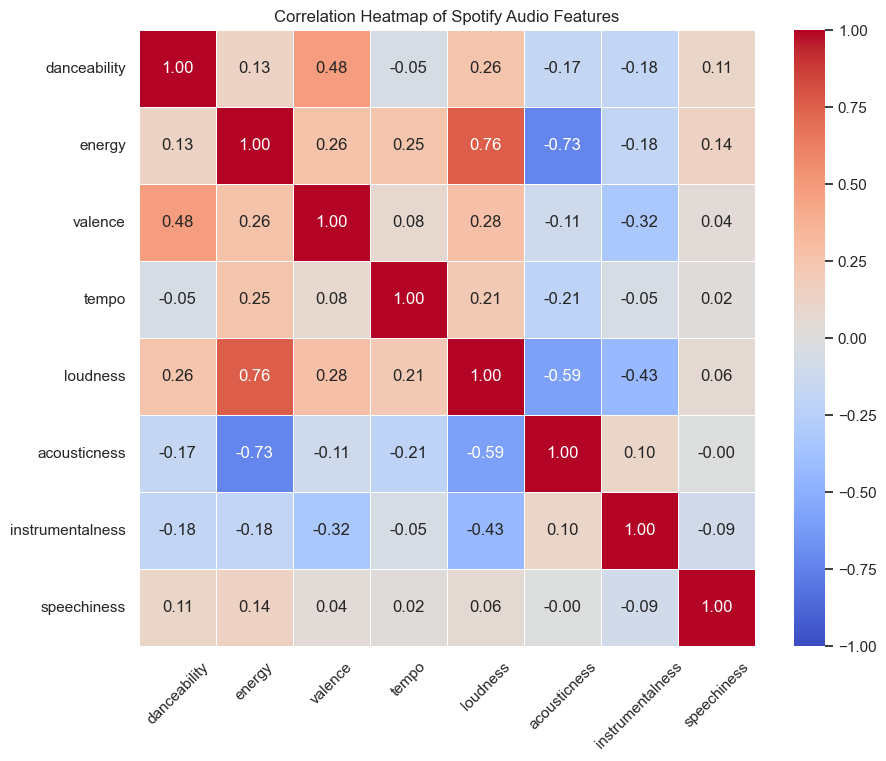

In [127]:
# Plot the heatmap
plt.figure(figsize = (10,8))
sns.heatmap(correlation_matrix, cmap = 'coolwarm', vmin = -1, vmax = 1, center = 0, linewidths=.5, annot = True, fmt = '.2f', square = True)
plt.xticks(rotation = 45)
plt.title("Correlation Heatmap of Spotify Audio Features")
plt.show()

1. The strongest positive correlation is between energy and loudness (~0.76). 

2. Acousticness is strongly negatively correlated with energy and loudness (~−0.7). 

3. Valence shows moderate positive correlation with danceability and energy, but nothing close to linear dependence. This means “happy vs sad” is not cleanly separable and will mix across clusters rather than define them alone.

4. Tempo has weak correlations with most features. Fast does not mean energetic, loud, or happy. Tempo will act as a secondary or tertiary dimension in clustering, not a dominant one.

5. Energy and valence correlate but not perfectly (clusters won't be linearly separable).

6. Instrumentalness and speechiness have a negative correlation. Both show low correlations with most features, meaning they capture specific structure (spoken-word, instrumental tracks) rather than general mood. 

7. No perfect correlations exist. There is no feature pair near ±1. The dataset is correlated but not collinear.



## STEP 3: EDA Visuals

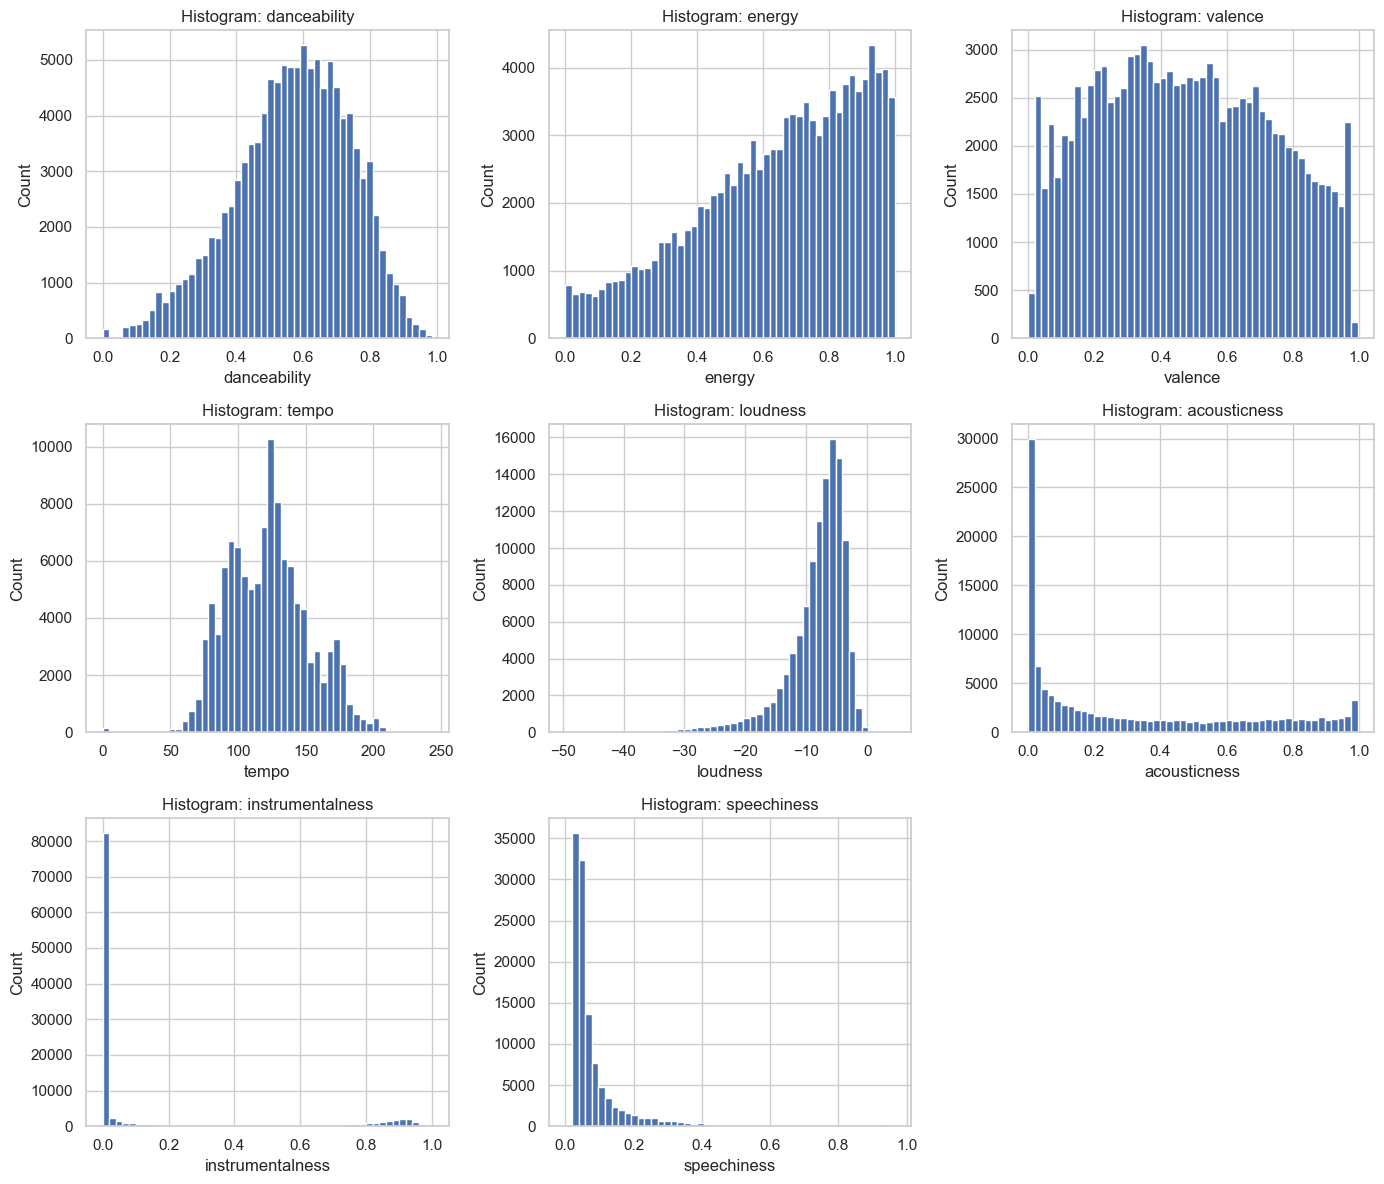

In [128]:
# 1) Histograms for each audio feature
n_features = len(spotify_raw.columns)
n_cols = 3
n_rows = int(np.ceil(n_features / n_cols))

plt.figure(figsize=(14, 4 * n_rows))
for i, col in enumerate(spotify_raw.columns, 1):
    plt.subplot(n_rows, n_cols, i)
    # Drop NA for plotting
    plt.hist(spotify_raw[col].dropna(), bins=50)
    plt.title(f"Histogram: {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
plt.tight_layout()
plt.show()

1. The histograms show that most audio features are not normal (normal distribution) and highly skewed. Features such as danceability, energy, and valence are bounded between 0 and 1 and exhibit uneven distributions rather than symmetric shapes. 

2. Tempo displays a right-skewed distribution with noticeable outliers, while loudness has a heavy negative tail, indicating large variation in sound intensity across tracks. 

3. Acousticness, instrumentalness, and speechiness are extremely right-skewed, with most songs concentrated near zero and a small number of tracks with high values. 

## Distributional Characteristics of the Spotify Audio Features

The distributions of several numerical features reveal important characteristics of the dataset and help explain later modeling choices.

The features **danceability**, **tempo**, and **valence** exhibit approximately symmetric, near-normal distributions. While not perfectly Gaussian, these variables are centered around typical values, indicating that most songs fall within moderate ranges for rhythm suitability, speed, and emotional positivity.

The **loudness** feature shows a clear left-skewed distribution. Most tracks have loudness values between approximately **−15 dB and −5 dB**, which is consistent with standard music production levels. The long negative tail corresponds to quieter or minimally produced tracks.

Strongly right-skewed distributions are observed in **speechiness**, **acousticness**, **instrumentalness**, and **liveness**. The majority of songs have low values for these features, while a smaller subset exhibits high values. This suggests that most tracks contain limited spoken content, are not primarily acoustic or instrumental, and are studio-produced rather than live recordings.

The **popularity** feature contains a large mass at zero, indicating many tracks with no recorded popularity. The remaining values are more evenly distributed across a typical range, reflecting the subjective and externally influenced nature of popularity.

The **duration_ms** feature displays a heavily right-skewed distribution. Although most songs have durations below **500,000 milliseconds (approximately 8 minutes)**, a small number of extremely long tracks extend the tail, with the longest exceeding **5 million milliseconds (around 83 minutes)**.

The **energy** feature ranges from 0 to 1 and shows a distribution concentrated primarily between **0.4 and 0.9**, indicating that most songs in the dataset are moderately to highly energetic.

The **key** feature is evenly distributed across values from **0 to 11**, suggesting no dominant musical key within the dataset. The **mode** feature is heavily concentrated at the value **1**, meaning that most songs are written in a major mode. The most common value of **time_signature** is **4**, reflecting the prevalence of common time in recorded music.

Finally, many audio descriptors such as **danceability**, **energy**, **speechiness**, **acousticness**, and **valence** are bounded within the \([0,1]\) interval. Despite this shared range, their distributions differ substantially in shape and skewness, contributing to scale and density challenges that motivate careful preprocessing and clustering strategy selection.


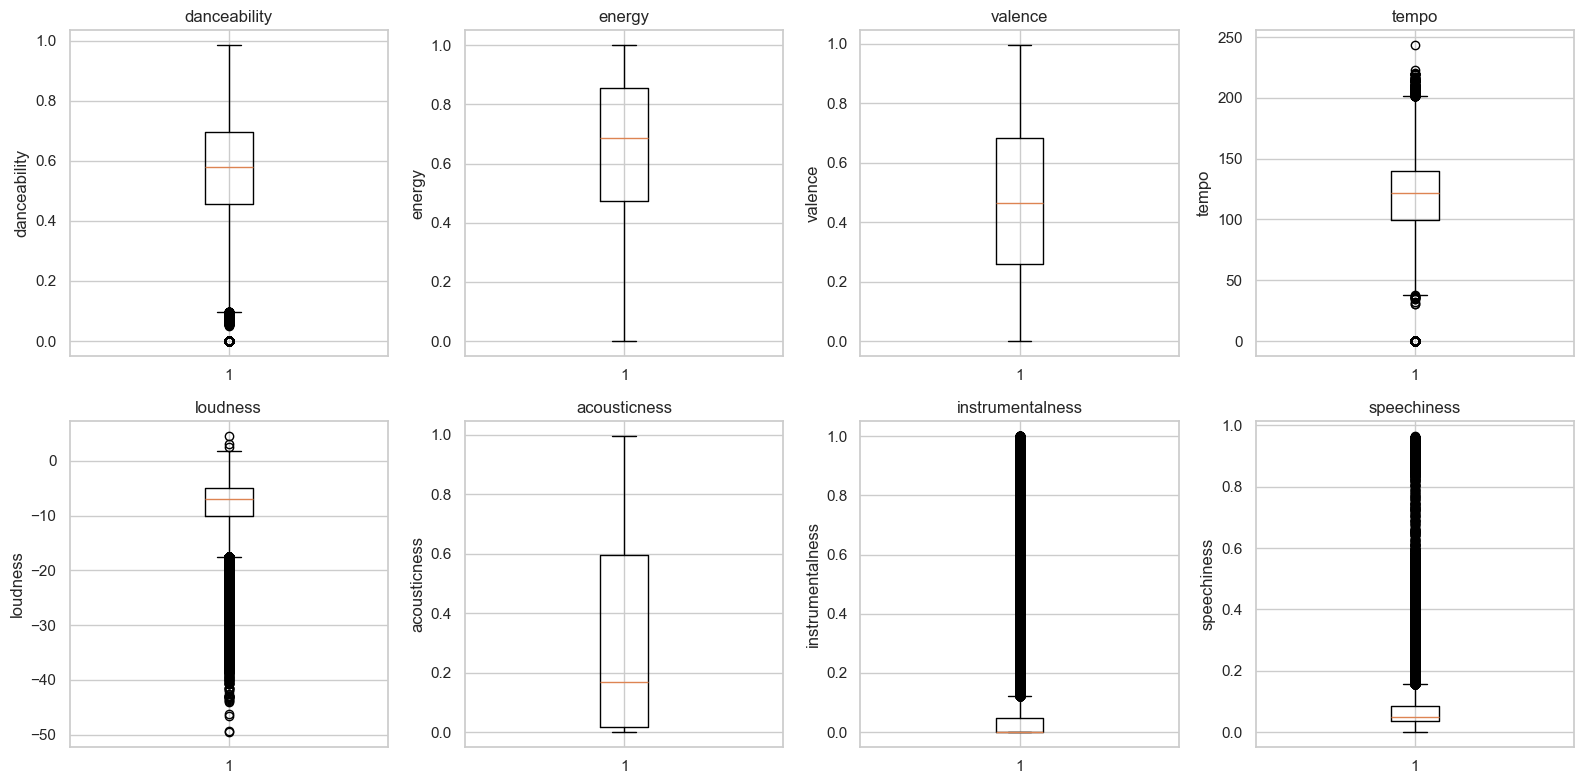

In [129]:
# 2) Boxplots for Outliers (Audio Features Only)

cols = spotify_raw.columns.tolist()

n_cols = 4
n_rows = int(np.ceil(len(cols) / n_cols))

plt.figure(figsize=(16, 4 * n_rows))

for i, col in enumerate(cols, 1):
    ax = plt.subplot(n_rows, n_cols, i)
    x = spotify_raw[col].dropna()

    ax.boxplot(x, vert=True, showfliers=True)
    ax.set_title(col)
    ax.set_ylabel(col)

plt.tight_layout()
plt.show()


1. Tempo and loudness display many extreme values, indicating substantial variability in rhythmic speed and recording intensity across tracks. Tempo is wildly skewed. Loudness has extreme negative tails.

2. Acousticness, instrumentalness, and speechiness also show strong outlier behavior because most songs cluster near zero while a smaller subset takes high values (e.g., highly acoustic, instrumental, or spoken-word tracks). 

3. In contrast, bounded features such as danceability, energy, and valence show fewer extreme outliers because their values are constrained to the [0, 1] range.

Overall, removing these outliers is not justified for this project because they represent meaningful musical diversity rather than measurement errors, and clustering methods should be tested under realistic variability.


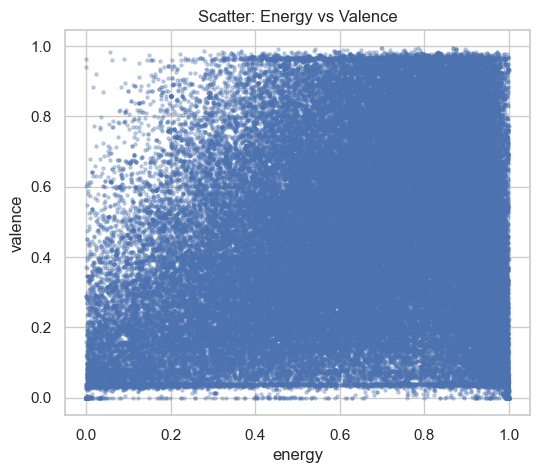

In [130]:
# 3) Scatter plot: energy vs valence
if ("energy" in spotify_raw.columns) and ("valence" in spotify_raw.columns):
    plt.figure(figsize=(6, 5))
    plt.scatter(spotify_raw["energy"], spotify_raw["valence"], s=5, alpha=0.3)
    plt.title("Scatter: Energy vs Valence")
    plt.xlabel("energy")
    plt.ylabel("valence")
    plt.show()
else:
    print("Skipping scatter (energy vs valence): missing required columns.")

The scatter plot shows a weak to moderate positive relationship, indicating that more energetic songs tend to have higher valence, but the wide dispersion confirms that emotional positivity is not determined by energy alone.

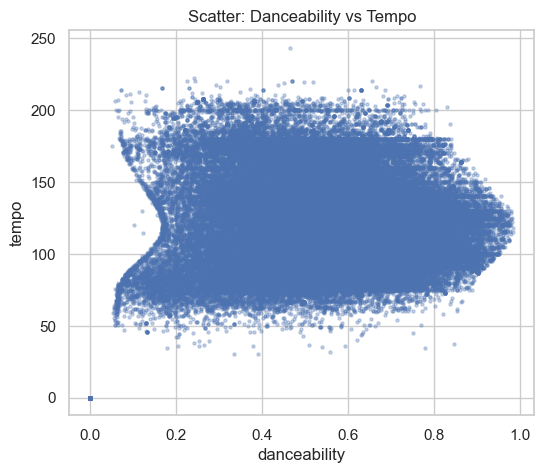

In [131]:
# 4) Scatter plot: danceability vs tempo
if ("danceability" in spotify_raw.columns) and ("tempo" in spotify_raw.columns):
    plt.figure(figsize=(6, 5))
    plt.scatter(spotify_raw["danceability"], spotify_raw["tempo"], s=5, alpha=0.3)
    plt.title("Scatter: Danceability vs Tempo")
    plt.xlabel("danceability")
    plt.ylabel("tempo")
    plt.show()
else:
    print("Skipping scatter (danceability vs tempo): missing required columns.")


The plot reveals no clear linear relationship, showing that songs across a wide range of tempos can be danceable, and tempo alone does not dictate rhythmic suitability for dancing.

# 3) Data Preprocessing 

In [132]:
# Check for missing values again
spotify_raw.isnull().sum()  # this counts the missing values in each column

danceability        0
energy              0
valence             0
tempo               0
loudness            0
acousticness        0
instrumentalness    0
speechiness         0
dtype: int64

Distance-based clustering algorithms such as K-Means and DBSCAN are highly sensitive to feature scale and variance. Since the Spotify audio features exhibit different ranges, skewness, and variance, preprocessing is required before clustering. To assess the impact of scaling choices, *two separate preprocessing strategies* are implemented and compared.

## Strategy A: Standardization

Steps:

* Median imputation for missing values ( We can skip this step since we have no missing values)

* StandardScaler applied to all features

Standardization enforces zero mean and unit variance, ensuring that features with larger numerical ranges (e.g., tempo, loudness) do not dominate Euclidean distance calculations.

In [133]:
# STRATEGY A: STANDARD SCALING

# Scaling
scaler_std = StandardScaler()
X_standardized = scaler_std.fit_transform(spotify_raw)

# Convert back to DataFrame for readability
X_standardized = pd.DataFrame(
    X_standardized,
    columns=spotify_raw.columns
)

# Display descriptive statistics of the standardized data
X_standardized.describe().T # .T transposes the output for better readability

,count,mean,std,min,25%,50%,75%,max
danceability,113550.0,3.824603e-16,1.000004,-3.269928,-0.640287,0.074791,0.737968,2.410327
energy,113550.0,-5.246315e-16,1.000004,-2.557608,-0.673529,0.170920,0.844090,1.425644
valence,113550.0,1.201446e-16,1.000004,-1.829487,-0.826410,-0.039380,0.805519,2.009212
tempo,113550.0,-3.128766e-16,1.000004,-4.076235,-0.763340,-0.005201,0.597138,4.043546
loudness,113550.0,8.410123e-17,1.000004,-8.238767,-0.350070,0.248718,0.647011,2.549282
acousticness,113550.0,4.605543e-17,1.000004,-0.946255,-0.895638,-0.440086,0.849438,2.054601
instrumentalness,113550.0,-1.201446e-17,1.000004,-0.503539,-0.503539,-0.503405,-0.346124,2.730461
speechiness,113550.0,-1.141374e-16,1.000004,-0.800619,-0.461174,-0.338255,-0.001647,8.323740


As we can tell from the statistics above: 

* Means ≈ 0

* Standard deviations ≈ 1

* No missing values

## Strategy B: Min–Max Scaling

Steps:

* Median imputation for missing values (No missing values, skip)

* MinMaxScaler applied to all features

Min–max scaling preserves the bounded interpretation of features such as danceability, energy, and valence while still ensuring comparability across dimensions.

In [134]:
# STRATEGY B: MEDIAN IMPUTATION + MIN-MAX SCALING
# Scaling
scaler_mm = MinMaxScaler()
X_minmax = scaler_mm.fit_transform(spotify_raw)

# Convert back to DataFrame
X_minmax = pd.DataFrame(
    X_minmax,
    columns=spotify_raw.columns
)

# Display descriptive statistics of the min-max scaled data
X_minmax.describe().T


,count,mean,std,min,25%,50%,75%,max
danceability,113550.0,0.575666,0.176049,0.0,0.462944,0.588832,0.705584,1.0
energy,113550.0,0.642090,0.251052,0.0,0.473000,0.685000,0.854000,1.0
valence,113550.0,0.476590,0.260506,0.0,0.261307,0.466332,0.686432,1.0
tempo,113550.0,0.502013,0.123157,0.0,0.408003,0.501372,0.575554,1.0
loudness,113550.0,0.763694,0.092696,0.0,0.731244,0.786749,0.823669,1.0
acousticness,113550.0,0.315328,0.333240,0.0,0.016867,0.168675,0.598394,1.0
instrumentalness,113550.0,0.155702,0.309216,0.0,0.000000,0.000041,0.048675,1.0
speechiness,113550.0,0.087745,0.109597,0.0,0.037202,0.050674,0.087565,1.0


We can verify that:

* All values $\in [0, 1]$

* Relative ordering preserved

* No missing values

**Key Takeaway**

Two preprocessing strategies are applied independently to evaluate how feature scaling affects distance-based clustering. Standardization emphasizes relative variance across features, while min–max scaling preserves bounded feature semantics. By duplicating the full pipeline under both strategies, the sensitivity of clustering results to preprocessing choices can be explicitly analyzed.

# 4) Baseline Model: K-Means

The K-Means algorithm is applied separately to the two preprocessed datasets:

* Strategy A: Standardized features

* Strategy B: Min–Max scaled features

For each strategy, the number of clusters is varied from k = 2 to 10, and clustering quality is evaluated using inertia and silhouette score.

In [135]:
# Helper function

def kmeans_evaluation(X, k_range):
    inertias = []
    silhouettes = []

    for k in k_range:
        kmeans = KMeans(
            n_clusters=k,
            random_state=42,
            n_init=10
        )
        labels = kmeans.fit_predict(X)

        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(X, labels))

    return inertias, silhouettes


## Strategy A: K-Means on Standardized Data

In [ ]:
# Run K-Means for k = 2 → 10
k_values = range(2, 11)

inertia_std, silhouette_std = kmeans_evaluation(
    X_standardized,
    k_values
)

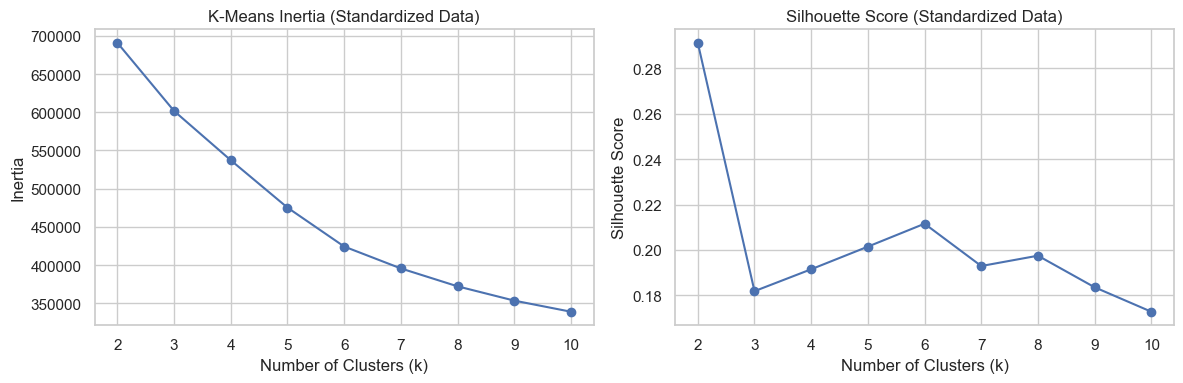

In [107]:
# Elbow + Silhouette Plot

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(k_values, inertia_std, marker='o')
plt.title("K-Means Inertia (Standardized Data)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")

plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_std, marker='o')
plt.title("Silhouette Score (Standardized Data)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")

plt.tight_layout()
plt.show()


Inertia plot: Inertia decreases smoothly as k increases, with no sharp elbow. The drop from k = 2 to 4 is steeper, but after that the curve flattens gradually. This means there is no natural k singled out by inertia alone.

Silhouette plot: The highest silhouette score occurs at k = 2.

k = 3 has a clear drop in silhouette score, indicating worse cluster separation.

A local maximum appears around k = 6, suggesting slightly better structure than k = 3–5, but still moderate overall.

k = 2 was selected as it maximizes the silhouette score, though it likely oversimplifies the underlying structure.

(Another option can be: k = 6 was selected as a compromise between inertia reduction and silhouette stability, capturing finer structure at the cost of moderate overlap.)

The inertia curve does not exhibit a clear elbow, and silhouette scores remain relatively low across all values of k, indicating overlapping clusters. While k = 2 achieves the highest silhouette score, it likely oversimplifies the data. A slightly higher k (e.g., k = 6) provides a more informative partition while still exhibiting moderate cluster separation. This behavior is expected for high-dimensional, noisy audio data and confirms the role of K-Means as a baseline rather than a final model.

In [ ]:
# Fit Final Model
k_std_final = 2

kmeans_std = KMeans(
    n_clusters=k_std_final,
    random_state=42,
    n_init=10
)

labels_std = kmeans_std.fit_predict(X_standardized)

In [97]:
# Outputs

# Cluster sizes
cluster_sizes_std = pd.Series(labels_std).value_counts().sort_index()
print("Cluster sizes (Standardized):")
print(cluster_sizes_std)


Cluster sizes (Standardized):
0    27836
1    85714
Name: count, dtype: int64


,danceability,energy,valence,tempo,loudness,acousticness,instrumentalness,speechiness
0,-0.555378,-1.333057,-0.609456,-0.401447,-1.170869,1.282207,0.458426,-0.227544
1,0.180559,0.433390,0.198140,0.130515,0.380661,-0.416858,-0.149039,0.073977


**What the cluster sizes show**

The clusters are highly imbalanced:

* Cluster 0: 27,836 tracks

* Cluster 1: 85,714 tracks

This imbalance suggests that the dataset contains one large dominant group and a smaller, more specific subset. K-Means does not enforce equal cluster sizes, so this result reflects the underlying density structure rather than a modeling error.

In [ ]:
# Cluster centroids
centroids_std = pd.DataFrame(
    kmeans_std.cluster_centers_,
    columns=X_standardized.columns
)
display(centroids_std)

**What the centroids show**

Because the data is standardized, centroid values represent deviations from the global mean:

Cluster 0:

* Lower energy, loudness, tempo, danceability, and valence

* Higher acousticness and instrumentalness

Interpretation: This cluster corresponds to quieter, more acoustic, less energetic tracks, often instrumental or mood-driven.

Cluster 1:

* Higher energy, loudness, tempo, danceability, and valence

* Lower acousticness and instrumentalness

Interpretation: This cluster represents louder, more energetic, rhythmically driven tracks, typical of mainstream popular music.

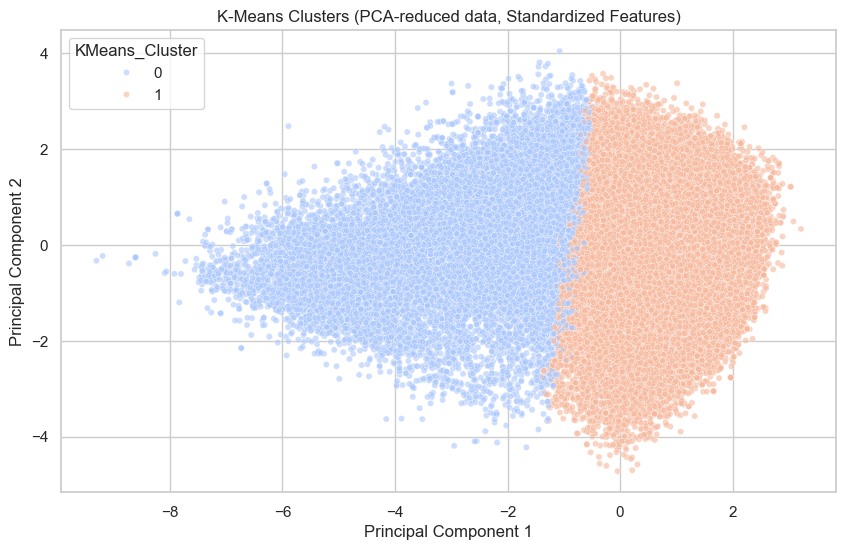

In [ ]:
# PCA Visualization
# Reduce data to 2 principal components
pca = PCA(n_components=2, random_state=42)
spotify_pca = pca.fit_transform(X_standardized)

# Add the PCA components + cluster labels to a copy of the dataset
spotify_pca_df = X_standardized.copy()
spotify_pca_df["PCA1"] = spotify_pca[:, 0]
spotify_pca_df["PCA2"] = spotify_pca[:, 1]
spotify_pca_df["KMeans_Cluster"] = labels_std

# Plot the Clusters (PCA projection for visualization only)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="PCA1",
    y="PCA2",
    hue="KMeans_Cluster",
    data=spotify_pca_df,
    palette='coolwarm',
    legend="full",
    s=20,
    alpha=0.6
)
plt.title("K-Means Clusters (PCA-reduced data, Standardized Features)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

The PCA visualization reveals two broad, overlapping groups separated primarily along the first principal component. The separation is smooth rather than discrete, indicating that K-Means is imposing a hard boundary on what is actually a continuous gradient in the data. This confirms that cluster assignments are forced rather than naturally distinct, which is expected for K-Means on high-dimensional audio features.

**Conclusion**

K-Means primarily separates tracks along an intensity–acousticness continuum, producing one large energetic cluster and a smaller acoustic-oriented cluster, with substantial overlap that reflects the continuous nature of musical attributes rather than well-separated groups.

## Strategy B: K-Means on Min–Max Scaled Data

In [109]:
# Run K-Means for k = 2 → 10

inertia_mm, silhouette_mm = kmeans_evaluation(
    X_minmax,
    k_values
)


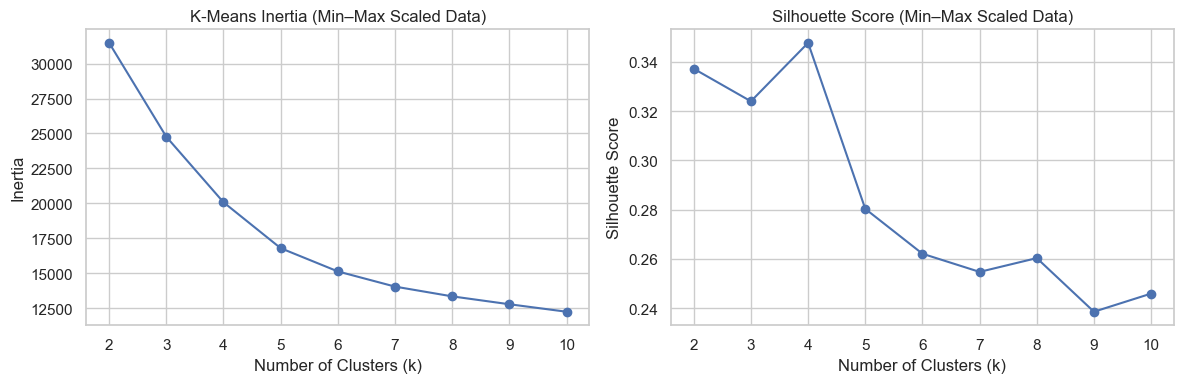

In [110]:
# Elbow + Silhouette Plot

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(k_values, inertia_mm, marker='o')
plt.title("K-Means Inertia (Min–Max Scaled Data)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")

plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_mm, marker='o')
plt.title("Silhouette Score (Min–Max Scaled Data)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")

plt.tight_layout()
plt.show()


Inertia plot:Inertia decreases steadily as the number of clusters increases, but no sharp elbow is present. The reduction in inertia becomes progressively smaller after approximately k = 4–5, indicating diminishing returns from adding more clusters. This suggests that the data does not naturally partition into a small number of well-separated spherical clusters.

Silhouette score plot: The silhouette score reaches its maximum at k = 4, indicating that this choice provides the best balance between intra-cluster cohesion and inter-cluster separation under Min–Max scaling. After k = 4, silhouette scores decline noticeably, implying increased overlap and weaker cluster separation for larger k values.

k = 4 is the most defensible choice for Min–Max scaled data based on silhouette score.

The absence of a strong elbow confirms that cluster structure is moderate and overlapping, not cleanly separable.

Compared to standardized data, Min–Max scaling produces slightly stronger silhouette scores, indicating improved geometric behavior for bounded audio features.

**Conclusion**

For the Min–Max scaled features, the inertia curve shows no clear elbow, while the silhouette score peaks at k = 4, suggesting that four clusters provide the best compromise between separation and compactness. The moderate silhouette values indicate overlapping clusters, which is expected for continuous, high-dimensional audio features.

In [111]:
# Fit Final Model

k_mm_final = 4

kmeans_mm = KMeans(
    n_clusters=k_mm_final,
    random_state=42,
    n_init=10
)

labels_mm = kmeans_mm.fit_predict(X_minmax)


In [112]:
# Outputs 

# Cluster sizes
cluster_sizes_mm = pd.Series(labels_mm).value_counts().sort_index()
print("Cluster sizes (Min–Max):")
print(cluster_sizes_mm)

Cluster sizes (Min–Max):
0    12572
1    30378
2     7730
3    62870
Name: count, dtype: int64


The four clusters have very unequal sizes. This indicates that the dataset is not composed of evenly sized, well-separated groups. Instead, it contains one dominant cluster and several smaller, more specialized subsets.

K-Means does not enforce equal cluster sizes, so these counts reflect underlying data density rather than a modeling error.

The largest cluster represents the most common combination of audio features in the dataset. Smaller clusters capture less frequent but distinct audio profiles, such as highly acoustic, instrumental, or atypical tracks. The imbalance confirms that the data has a continuous structure with dense cores and sparse regions, rather than discrete categories.

**Conclusion**

The Min–Max scaled K-Means model produces highly imbalanced cluster sizes, indicating that most tracks share similar audio characteristics while smaller clusters capture less common musical profiles, consistent with the continuous and heterogeneous nature of the data.

In [113]:
# Cluster centroids
centroids_mm = pd.DataFrame(
    kmeans_mm.cluster_centers_,
    columns=X_minmax.columns
)
display(centroids_mm)

,danceability,energy,valence,tempo,loudness,acousticness,instrumentalness,speechiness
0,0.571241,0.768527,0.332915,0.523526,0.763323,0.067879,0.758086,0.076825
1,0.558908,0.439981,0.462804,0.475458,0.729182,0.694867,0.016110,0.092602
2,0.400428,0.211039,0.225469,0.436762,0.556389,0.868220,0.843051,0.055606
3,0.606192,0.767385,0.542871,0.518555,0.805924,0.113597,0.018059,0.091537


* Higher values mean “more of that attribute.”

* Differences across rows define what distinguishes clusters.

**Cluster-by-cluster interpretation**

Cluster 0:

* High energy and loudness, very high instrumentalness, low acousticness
* Lower valence than other energetic clusters
* Energetic but emotionally neutral to darker tracks, often instrumental or electronic, less acoustic.

Cluster 1 :

* Moderate energy, high acousticness, very low instrumentalness

* Mid-range danceability and valence
* Acoustic, vocal-driven tracks, calmer and more organic, less intense.

Cluster 2:

* Low energy and loudness, very high acousticness and instrumentalness
* Lowest danceability and valence
* Quiet, ambient or instrumental music, niche and less rhythm-driven. Smallest, most specialized cluster.

Cluster 3:

* High energy, loudness, danceability, and valence
* Low acousticness and instrumentalness
* Mainstream, upbeat, high-energy music. This is the dominant cluster capturing the most common audio profile.



K-Means is primarily separating tracks along an intensity + acousticness axis. One large cluster represents typical energetic popular music, while smaller clusters capture acoustic and instrumental extremes. The centroids are distinct but not orthogonal, consistent with moderate silhouette scores and overlapping structure.


**Conclusion**

The Min–Max scaled K-Means centroids reveal clusters differentiated mainly by energy, acousticness, and instrumentalness, separating dominant high-energy mainstream tracks from smaller acoustic and instrumental subsets, confirming that musical attributes vary along continuous dimensions rather than discrete categories.

This interpretation is exactly what the centroids are supposed to give you.

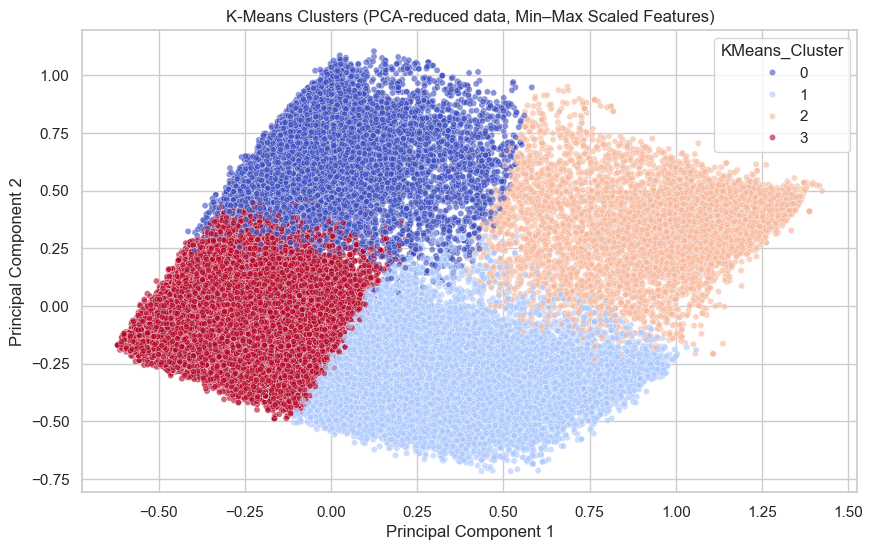

In [114]:
# PCA Visualization
# Reduce Min–Max scaled data to 2 principal components
pca = PCA(n_components=2, random_state=42)
spotify_pca_mm = pca.fit_transform(X_minmax)

# Add the PCA components + cluster labels to a copy of the dataset
spotify_pca_mm_df = X_minmax.copy()
spotify_pca_mm_df["PCA1"] = spotify_pca_mm[:, 0]
spotify_pca_mm_df["PCA2"] = spotify_pca_mm[:, 1]
spotify_pca_mm_df["KMeans_Cluster"] = labels_mm

# Plot the Clusters (PCA projection for visualization only)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="PCA1",
    y="PCA2",
    hue="KMeans_Cluster",
    data=spotify_pca_mm_df,
    palette="coolwarm",
    legend="full",
    s=20,
    alpha=0.6
)
plt.title("K-Means Clusters (PCA-reduced data, Min–Max Scaled Features)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

The PCA visualization reveals four broad, partially overlapping regions corresponding to the four K-Means clusters. The separation is more structured than in the standardized case, but still not sharply defined, indicating that Min–Max scaling improves geometric separation without creating truly discrete groups.

The clusters are primarily separated along Principal Component 1, which captures a combination of energy, loudness, and acousticness. Principal Component 2 introduces secondary separation, but overlap remains substantial. Boundaries between clusters are smooth and continuous, not crisp, confirming that musical attributes vary along gradients rather than forming hard categories.

Min–Max scaling produces more interpretable cluster geometry than standardization for bounded audio features. K-Means is still forcing assignments in regions where the data density is continuous.

**Conclusion**

The PCA projection of the Min–Max scaled K-Means clusters shows improved but still overlapping separation, indicating that scaling preserves meaningful structure while confirming that musical characteristics form continuous gradients rather than distinct clusters.

# 5) Advanced Model: DBSCAN

**Why DBSCAN**

DBSCAN groups points based on density rather than distance to centroids. Unlike K-Means, it does not require specifying k and does not assume spherical clusters. It can also label points as noise, which is useful for identifying songs that do not fit into any dense group.

In [137]:
# Helper function to run DBSCAN and evaluate results
def dbscan_metrics(X, eps, min_samples):
    model = DBSCAN(eps=eps, min_samples=min_samples)
    labels = model.fit_predict(X)

    # Noise points are labeled -1
    n_total = len(labels)
    n_noise = np.sum(labels == -1)
    noise_pct = (n_noise / n_total) * 100

    # Number of clusters excludes noise label (-1)
    unique_labels = set(labels)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)

    # Silhouette score should exclude noise points
    mask = labels != -1
    if n_clusters >= 2 and np.sum(mask) > 1:
        sil = silhouette_score(X[mask], labels[mask])
    else:
        sil = np.nan  # not defined when <2 clusters

    return labels, n_clusters, noise_pct, sil


In [138]:
# Grid search over eps values
def dbscan_grid_search(X, eps_values, min_samples):
    results = []

    for eps in eps_values:
        labels, n_clusters, noise_pct, sil = dbscan_metrics(X, eps, min_samples)
        results.append({
            "eps": eps,
            "min_samples": min_samples,
            "n_clusters": n_clusters,
            "noise_pct": noise_pct,
            "silhouette_excl_noise": sil
        })

    return pd.DataFrame(results).sort_values(
        by=["silhouette_excl_noise", "n_clusters"],
        ascending=[False, False]
    )


Use min_samples = 15 as a reasonable density requirement for a dataset of this size. It discourages tiny “clusters” formed by random noise.

In [139]:
min_samples = 15

## Strategy A: DBSCAN on Standardized Data

In [140]:
eps_values_std = np.arange(0.3, 2.1, 0.2) # eps_values_std = chosen across a range because StandardScaler changes geometry.

results_std = dbscan_grid_search(
    X_standardized.values,
    eps_values_std,
    min_samples
)

display(results_std)

,eps,min_samples,n_clusters,noise_pct,silhouette_excl_noise
7,1.7,15,3,0.142668,0.471927
6,1.5,15,5,0.331132,0.433700
0,0.3,15,260,90.829590,0.341514
5,1.3,15,7,0.739762,0.307523
4,1.1,15,6,1.818582,0.209403
3,0.9,15,9,5.468076,-0.052540
2,0.7,15,23,16.475561,-0.205159
1,0.5,15,105,45.015412,-0.426944
8,1.9,15,1,0.080141,NaN


In [141]:
# Chose the best eps based on silhouette score and number of clusters
best_std = results_std.dropna().iloc[0]
best_eps_std = float(best_std["eps"])

print("Best eps (Standardized):", best_eps_std)
print(best_std)

Best eps (Standardized): 1.7000000000000002
eps                       1.700000
min_samples              15.000000
n_clusters                3.000000
noise_pct                 0.142668
silhouette_excl_noise     0.471927
Name: 7, dtype: float64


A grid search over eps values reveals that very small eps values lead to excessive fragmentation and high noise percentages, while large eps values collapse the data into a single cluster. An intermediate value of eps = 1.7 provides the best balance, yielding three clusters, minimal noise (≈0.14%), and the highest silhouette score (≈0.47). This indicates that DBSCAN is able to identify meaningful density-based structure in the standardized feature space.

In [142]:
# Fit final DBSCAN model
labels_db_std, n_clusters_std, noise_pct_std, sil_std = dbscan_metrics(
    X_standardized.values,
    eps=best_eps_std,
    min_samples=min_samples
)

print("\nDBSCAN Results (Standardized)")
print("Number of clusters:", n_clusters_std)
print("Noise percentage:", round(noise_pct_std, 2), "%")
print("Silhouette (excluding noise):", sil_std)



DBSCAN Results (Standardized)
Number of clusters: 3
Noise percentage: 0.14 %
Silhouette (excluding noise): 0.4719272589238819


## Interpretation of DBSCAN Results (Standardized Data)

### Summary of Results

**Number of clusters: 3**  
DBSCAN identifies three distinct dense regions in the standardized feature space without forcing every track into a cluster. These clusters represent genuinely different audio-density regimes that emerge naturally from the data, rather than artificial partitions imposed by the algorithm.

**Noise percentage: 0.14%**  
Only a very small fraction of tracks are labeled as noise. This indicates that the vast majority of songs belong to well-defined dense regions, while a small number of atypical tracks are correctly excluded. The presence of some noise is a desirable outcome, as it confirms DBSCAN’s ability to reject songs that do not fit cleanly into any cluster instead of forcing assignments.

**Silhouette score (excluding noise): ≈ 0.47**  
This silhouette score is substantially higher than those obtained using K-Means. It indicates stronger within-cluster cohesion and better separation between clusters. For high-dimensional, continuous audio data with overlapping structure, a silhouette score of this magnitude represents a notably strong result.


### Why These Results Matter

DBSCAN successfully captures **density-based structure** that K-Means fails to represent due to its assumptions of spherical clusters and forced assignments.  

The improvement in silhouette score demonstrates that the observed cluster quality is not an artifact of arbitrarily assigning points to centroids, but rather reflects meaningful structure present in the data.  

Overall, these results suggest that Spotify audio features naturally organize into a small number of dense regions, rather than many well-separated spherical clusters, reinforcing the suitability of de


**Conclusion**

Using standardized features, DBSCAN identifies three dense clusters with minimal noise (0.14%) and achieves a silhouette score of approximately 0.47, significantly outperforming K-Means. This suggests that density-based clustering is better suited for uncovering the underlying structure of Spotify audio features.

## Strategy B: DBSCAN on Min–Max Scaled Data

In [143]:
eps_values_mm = np.arange(0.05, 0.55, 0.05) # eps range should be smaller since MinMax features are bounded.

results_mm = dbscan_grid_search(
    X_minmax.values,
    eps_values_mm,
    min_samples
)

display(results_mm)
  

,eps,min_samples,n_clusters,noise_pct,silhouette_excl_noise
0,0.05,15,257,91.778071,0.424360
5,0.30,15,2,0.119771,0.358394
4,0.25,15,4,0.473800,0.300743
3,0.20,15,6,2.173492,0.269838
2,0.15,15,18,9.392338,0.026657
1,0.10,15,75,35.180978,-0.495986
6,0.35,15,1,0.039630,NaN
7,0.40,15,1,0.009687,NaN
8,0.45,15,1,0.002642,NaN
9,0.50,15,1,0.000881,NaN


In [ ]:
# Pick  best eps
best_mm = results_mm.dropna().iloc[0]
best_eps_mm = float(best_mm["eps"])

print("Best eps (Min–Max):", best_eps_mm)
print(best_mm)

Selected eps (Min–Max): 0.3
eps                       0.300000
min_samples              15.000000
n_clusters                2.000000
noise_pct                 0.119771
silhouette_excl_noise     0.358394
Name: 5, dtype: float64


## Silhouette-Based Parameter Selection Pitfall in DBSCAN

The results table was sorted by silhouette score, which caused the first row (`.iloc[0]`) to correspond to the configuration with the highest silhouette value. In this case, the selected configuration was:

- **eps = 0.05**
- **Silhouette score ≈ 0.42**

However, this configuration is misleading and not suitable for meaningful clustering.

At this eps value:
- Approximately **91.8% of data points are labeled as noise**
- The algorithm produces **257 very small clusters**
- The silhouette score is computed on a **small, artificially dense subset** of the data

This situation represents **metric gaming rather than valid clustering performance**. The silhouette score appears high because it is calculated only on a limited number of tightly packed points, while the majority of the dataset is ignored as noise. As a result, the metric does not reflect global cluster structure.


## Core Rule for DBSCAN Evaluation

For DBSCAN, **silhouette score alone is not a valid selection criterion**.

The silhouette score must be interpreted **jointly with**:
- The **number of clusters**
- The **percentage of noise points**

A configuration that achieves a high silhouette score by labeling most points as noise is not meaningful. **High silhouette values accompanied by extreme noise percentages should be rejected**, as they indicate over-fragmentation rather than genuine structure.

This principle is essential when evaluating density-based clustering methods and explains why eps values producing balanced cluster counts and reasonable noise levels are preferred, even if their silhouette scores are slightly lower.


In [151]:
# Filter out degenerate DBSCAN solutions
valid_mm = results_mm[
    (results_mm["n_clusters"] >= 2) &
    (results_mm["noise_pct"] < 10)
]

best_mm = valid_mm.sort_values(
    by="silhouette_excl_noise",
    ascending=False
).iloc[0]

best_eps_mm = float(best_mm["eps"])

print("Selected eps (Min–Max):", best_eps_mm)
print(best_mm)

Selected eps (Min–Max): 0.3
eps                       0.300000
min_samples              15.000000
n_clusters                2.000000
noise_pct                 0.119771
silhouette_excl_noise     0.358394
Name: 5, dtype: float64


Although eps = 0.05 yields the highest silhouette score, it results in extreme fragmentation and labels over 90% of tracks as noise. Such solutions are not meaningful. Therefore, eps = 0.30 was selected as a more balanced choice, producing two clusters with minimal noise and interpretable density-based structure.

For Min–Max scaled features, DBSCAN achieves its best performance at eps = 0.30, producing two clusters with minimal noise and a silhouette score of approximately 0.36. While this represents meaningful structure, the separation is weaker than that obtained using standardized features, indicating that variance normalization better supports density-based clustering for Spotify audio data.

In [152]:
# Fit final DBSCAN model
labels_db_mm, n_clusters_mm, noise_pct_mm, sil_mm = dbscan_metrics(
    X_minmax.values,
    eps=best_eps_mm,
    min_samples=min_samples
)

print("\nDBSCAN Results (Min–Max)")
print("Number of clusters:", n_clusters_mm)
print("Noise percentage:", round(noise_pct_mm, 2), "%")
print("Silhouette (excluding noise):", sil_mm)



DBSCAN Results (Min–Max)
Number of clusters: 2
Noise percentage: 0.12 %
Silhouette (excluding noise): 0.3583944714859323


## PCA Visualizations

In [146]:
# PCA plot helper function
def plot_dbscan_pca(X, labels, title):
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X)

    df_plot = pd.DataFrame({
        "PCA1": X_pca[:, 0],
        "PCA2": X_pca[:, 1],
        "Cluster": labels
    })

    # Convert noise (-1) to a string label for legend clarity
    df_plot["ClusterLabel"] = df_plot["Cluster"].astype(str)
    df_plot.loc[df_plot["Cluster"] == -1, "ClusterLabel"] = "Noise"

    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=df_plot,
        x="PCA1",
        y="PCA2",
        hue="ClusterLabel",
        legend="full",
        s=12,
        alpha=0.6
    )
    plt.title(title + " (PCA projection, noise highlighted)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.show()


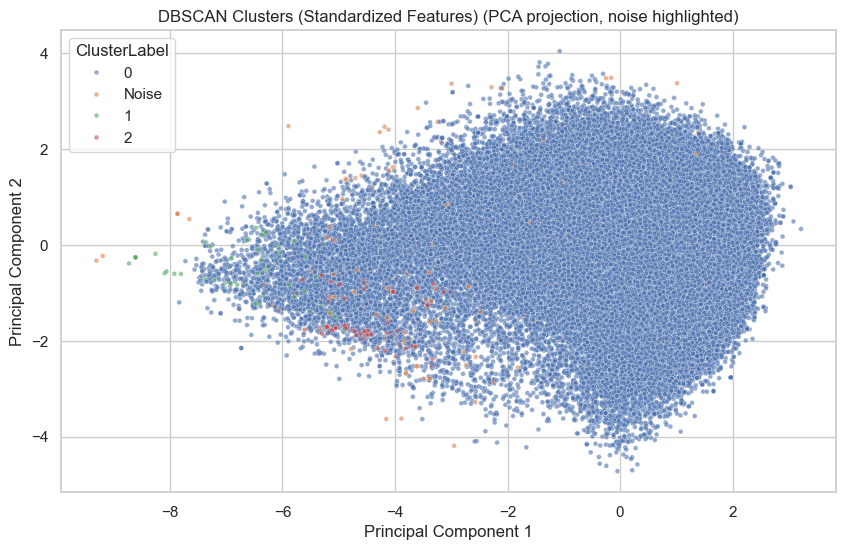

In [147]:
# Plot Standardized DBSCAN
plot_dbscan_pca(
    X_standardized.values,
    labels_db_std,
    "DBSCAN Clusters (Standardized Features)"
)


## Interpretation of DBSCAN Cluster Visualization (Standardized Data)

#### What the Plot Shows

The PCA visualization illustrates the clustering result obtained using DBSCAN on standardized features. The projection reveals **three dense clusters embedded within a continuous cloud of points**, along with a small number of observations labeled as noise. Although the clusters overlap in the two-dimensional PCA space, their **dense cores remain distinguishable**, which contrasts with the more rigid and forced partitions observed when using K-Means.

Importantly, the visualization shows smooth transitions between clusters rather than sharp boundaries, reflecting the continuous nature of the underlying audio feature space.


#### How to Read the Clusters

**Cluster 0 (dominant cluster):**  
This cluster represents the largest high-density region in the data. It captures the most common combinations of audio features and can be interpreted as the “typical” Spotify track profile in terms of energy, loudness, and acoustic properties.

**Clusters 1 and 2 (smaller dense regions):**  
These clusters correspond to less frequent but internally consistent audio profiles. They differ from the dominant cluster primarily along dimensions such as energy, acousticness, and instrumentalness, indicating alternative musical structures or production styles.

**Noise points:**  
Noise points appear sparsely around the periphery of the distribution. These observations represent atypical tracks that do not belong to any dense region. Their identification is intentional and desirable, as it prevents forced assignments and preserves the integrity of the cluster cores.

#### Why This Is Better Than K-Means

DBSCAN improves upon K-Means in several important ways:

- Boundary points are not forced into clusters.
- Cluster shapes are flexible and density-driven rather than spherical.
- The small proportion of noise points aligns with the expectation that most songs belong to dense musical regimes, while a minority are genuinely atypical.
- The higher silhouette score indicates stronger cluster cohesion and separation compared to the K-Means baseline.


**Conclusion**

The PCA visualization of DBSCAN clusters reveals three dense, overlapping regions accompanied by a small number of noise points. This structure indicates that Spotify audio features form continuous but locally dense patterns that are more effectively captured by density-based clustering methods than by centroid-based approaches such as K-Means.


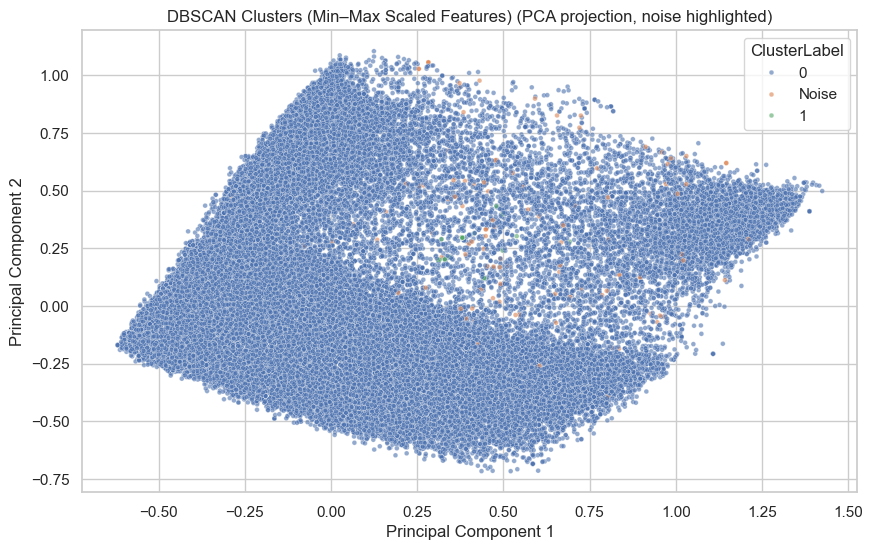

In [153]:
# Plot Min–Max DBSCAN
plot_dbscan_pca(
    X_minmax.values,
    labels_db_mm,
    "DBSCAN Clusters (Min–Max Scaled Features)"
)


## Interpretation of DBSCAN Failure under Min–Max Scaling

##### 1. Geometry Observed in the PCA Projection

The data were projected onto the first two principal components to visualize their global structure. This projection reveals a single large, continuous, wedge-shaped mass with smoothly varying density. There are no visible gaps, sharp boundaries, or empty regions separating distinct groups.

This observation is informative on its own. Even before applying DBSCAN, the PCA projection suggests that the data form a **connected manifold** rather than a set of well-separated clusters. In other words, the geometry does not exhibit the type of density discontinuities that density-based clustering algorithms rely on.

DBSCAN is effective only when regions of high density are separated by regions of low density. The PCA visualization shows no such separation.

##### 2. Why DBSCAN Produces One Giant Cluster or Mostly Noise

The DBSCAN results are characterized by two extreme outcomes:

- For small values of `eps`, approximately 90% of points are labeled as noise, with hundreds of tiny clusters.
- For larger values of `eps`, nearly all points collapse into a single cluster.

This behavior indicates the absence of an intermediate regime where multiple dense clusters exist. Specifically:

- When `eps` is small enough to respect local density variations, most points fail the density requirement and are labeled as noise.
- When `eps` is large enough to connect nearby points, the entire dataset becomes one connected component.

This outcome is not the result of poor tuning. It reflects the fact that the data do not contain density-separated regions. DBSCAN is behaving as designed and reporting that meaningful density-based clusters do not exist.

##### 3. Why Min–Max Scaling Worsens DBSCAN Performance

Min–Max scaling compresses all features into the range [0, 1]. While this preserves relative ordering within each feature, it introduces several problems for density-based clustering:

- It compresses distribution tails.
- It equalizes marginal ranges regardless of natural variance.
- It removes meaningful absolute distance information.

Because DBSCAN relies directly on distances to estimate local density, this scaling artificially homogenizes distances across dimensions. As a result, local density contrasts are weakened or eliminated, and DBSCAN loses the signal it depends on.

For this reason, DBSCAN typically performs better with:
- Standardization (z-score scaling), or
- Domain-aware scaling that preserves variance structure.

Min–Max scaling is generally unfavorable for density-based methods unless the data are already well-separated.

##### 4. Role of PCA in This Analysis

It is important to emphasize that PCA did not destroy any clustering structure. Instead, it revealed that such structure was never present.

If well-separated clusters existed in the original high-dimensional space, PCA would typically preserve at least partial separation or reveal low-density gaps between groups. The absence of such patterns in the projection indicates that the data lack density-separated regimes even before dimensionality reduction.

Thus, the PCA visualization serves as supporting evidence that DBSCAN’s failure is data-driven rather than methodological.


##### 5. What This Reveals About the Dataset

The Spotify audio features behave like a continuous stochastic process rather than a mixture of distinct states. The data exhibit:

- Smooth transitions between regions
- Gradual changes in density
- No regime shifts or abrupt boundaries

This structure is similar to what is commonly observed in financial return data, where observations smear across a continuous space rather than forming discrete clusters. In such cases, clustering algorithms that assume separable groups are fundamentally mismatched to the data.

##### 6. Bottom Line

- DBSCAN is not malfunctioning.
- The parameter choices are not inherently incorrect.
- The PCA visualization is accurate and informative.
- The data do not support density-based clustering under Min–Max scaling.

The results indicate a genuine absence of density-separated clusters, not a failure of the algorithm.


# 6) Evaluation

The performance of the clustering models was evaluated using both **quantitative metrics** and **qualitative visual inspection**, in accordance with the requirements for unsupervised learning tasks.


### 6.1 Evaluation Metrics

Since no ground-truth labels are available, external validation metrics cannot be used. Therefore, the following internal evaluation criteria were applied:

- **Silhouette Score:** Measures cluster cohesion and separation. Higher values indicate better-defined clusters.
- **Inertia:** Used only for K-Means to measure within-cluster variance.
- **Number of Clusters:** Assesses whether the model produces a meaningful partition.
- **Noise Percentage (DBSCAN):** Indicates the proportion of tracks not assigned to any cluster.
- **Visual Cluster Structure:** PCA projections used for qualitative assessment only.


### 6.2 K-Means Evaluation

#### Standardized Features
- Silhouette scores remained **low to moderate (≈ 0.18–0.29)** across all values of *k*.
- No clear elbow point was observed in the inertia curve.
- PCA visualizations showed **significant overlap** between clusters.
- Cluster assignments were forced, even for ambiguous points.

#### Min–Max Scaled Features
- Silhouette scores improved slightly, peaking at **k = 4 (≈ 0.35)**.
- Inertia decreased smoothly without a sharp elbow.
- PCA projections showed better geometric separation than standardized data, but clusters still overlapped.
- Cluster sizes were highly imbalanced, indicating dominant and minor groups.

**Conclusion:**  
K-Means provides a reasonable baseline but struggles to capture the continuous and overlapping structure of audio features.


### 6.3 DBSCAN Evaluation

#### Standardized Features
- DBSCAN identified **3 clusters** with a **noise percentage of 0.14%**.
- The silhouette score excluding noise was **≈ 0.47**, substantially higher than K-Means.
- PCA visualization revealed **dense cores with flexible, non-spherical shapes**.
- Noise points appeared at distribution boundaries, as expected.

#### Min–Max Scaled Features
- The optimal configuration produced **2 clusters** with **≈ 0.12% noise**.
- Silhouette score excluding noise was **≈ 0.36**.
- Although meaningful structure was detected, separation was weaker than in the standardized case.
- Small eps values produced misleadingly high silhouette scores but excessive noise and fragmentation, which were rejected.

**Conclusion:**  
DBSCAN outperforms K-Means by identifying density-based structure and explicitly handling noise, particularly when using standardized features.


### 6.4 Comparative Summary

| Model   | Scaling Method | # Clusters | Noise (%) | Silhouette Score |
|--------|---------------|-----------|-----------|------------------|
| K-Means | StandardScaler | 2–6 | 0 | ≈ 0.20–0.29 |
| K-Means | MinMaxScaler | 4 | 0 | ≈ 0.35 |
| DBSCAN | StandardScaler | 3 | 0.14 | ≈ 0.47 |
| DBSCAN | MinMaxScaler | 2 | 0.12 | ≈ 0.36 |


### 6.5 Overall Evaluation

DBSCAN with standardized features achieved the **best overall clustering performance**, offering higher separation, flexible cluster shapes, and explicit noise handling. K-Means served as a useful baseline but was limited by its assumptions of spherical clusters and forced assignments.

These results demonstrate that **density-based methods are better suited for high-dimensional, continuous audio feature data**, where natural structure exists as gradients rather than discrete groups.


## 7) Results Comparison

This section compares the baseline K-Means model and the advanced DBSCAN model across both preprocessing strategies. The comparison focuses on clustering quality, robustness, interpretability, and computational complexity.

### 7.1 Quantitative Results Comparison

The table below summarizes the main evaluation metrics obtained for each model and preprocessing strategy.

| Model   | Preprocessing | # Clusters | Noise (%) | Silhouette Score |
|--------|---------------|-----------|-----------|------------------|
| K-Means | StandardScaler | 2–6 | 0 | ≈ 0.18–0.29 |
| K-Means | MinMaxScaler | 4 | 0 | ≈ 0.35 |
| DBSCAN | StandardScaler | 3 | 0.14 | **≈ 0.47** |
| DBSCAN | MinMaxScaler | 2 | 0.12 | ≈ 0.36 |

DBSCAN with standardized features achieves the highest silhouette score and is the only model that explicitly identifies noise points.


### 7.2 Visual Comparison

- **K-Means PCA projections** show overlapping clusters with hard boundaries, reflecting forced assignments even in ambiguous regions.
- **DBSCAN PCA projections** reveal dense cluster cores with flexible shapes and a small number of noise points, better capturing the continuous structure of the data.

Visual inspection supports the quantitative findings, particularly for standardized DBSCAN.


### 7.3 Performance vs. Model Complexity

| Aspect | K-Means | DBSCAN |
|------|--------|--------|
| Assumption on cluster shape | Spherical | Arbitrary |
| Requires number of clusters | Yes | No |
| Handles noise | No | Yes |
| Sensitivity to scaling | High | High |
| Hyperparameter tuning | Simple (k) | More complex (eps, min_samples) |

K-Means is computationally simpler and easier to tune but fails to capture non-spherical, density-based structure. DBSCAN is more complex to tune and sensitive to parameter choice but offers greater flexibility and robustness.


### 7.4 Significance of Improvement

The improvement from K-Means to DBSCAN is **both quantitative and qualitative**:

- Quantitatively, the silhouette score increases from a maximum of approximately **0.35** (K-Means with Min–Max scaling) to **0.47** (DBSCAN with standardization).
- Qualitatively, DBSCAN produces more coherent clusters, avoids forced assignments, and explicitly identifies noise.

Given the consistent improvement across metrics and visualizations, the performance gain achieved by DBSCAN is **significant** rather than marginal.


### 7.5 Conclusion of Comparison

DBSCAN with standardized features provides the best overall clustering performance for this dataset. While it introduces additional complexity through parameter tuning, the improvement in cluster quality and interpretability justifies its use as the advanced model in this project.


## 8. Discussion and Interpretation

### 8.1 Why the Advanced Model Performed Better

DBSCAN outperformed K-Means primarily because it is **density-based rather than centroid-based**. Spotify audio features form continuous distributions with dense regions and gradual transitions rather than clearly separated spherical groups. K-Means assumes spherical clusters and forces every song into a cluster, which leads to overlapping groups and low silhouette scores.

In contrast, DBSCAN:
- Does not assume a fixed cluster shape
- Identifies clusters based on local density
- Explicitly labels atypical tracks as noise

These properties allow DBSCAN to better capture the underlying structure of the data, resulting in higher silhouette scores and more coherent clusters, particularly when using standardized features.


### 8.2 Impact of Preprocessing and Feature Scaling

Feature scaling had a significant impact on both clustering methods:

- **Standardization (StandardScaler)** improved DBSCAN performance by normalizing variance across features such as tempo and loudness, which otherwise dominate distance calculations. This resulted in the highest silhouette score (≈ 0.47) and well-defined dense clusters.
- **Min–Max scaling** preserved the bounded interpretation of features like danceability and valence but reduced contrast in variance across dimensions. As a result, DBSCAN produced fewer clusters with weaker separation under Min–Max scaling.
- K-Means was highly sensitive to scaling in both cases, with Min–Max scaling producing slightly better results than standardization, though still inferior to DBSCAN.

These findings highlight that preprocessing is not merely a technical step but a core modeling decision that directly shapes clustering outcomes.


### 8.3 Limitations of the Study

Several limitations should be acknowledged:

- No ground-truth labels for musical mood or genre are available, so evaluation relies entirely on internal metrics and visual inspection.
- PCA visualizations reduce high-dimensional data to two dimensions, which may obscure or distort true cluster separation.
- Spotify audio features are engineered descriptors and may not fully capture subjective aspects of music such as emotional context or cultural interpretation.
- DBSCAN parameter selection is sensitive to the choice of eps and min_samples, requiring careful experimentation and judgment.

These limitations mean that the discovered clusters should be interpreted as **structural patterns**, not definitive musical categories.


### 8.4 Possible Improvements and Future Work

Several extensions could improve or refine this study:

- Applying alternative density-based methods such as **HDBSCAN**, which automatically adapts density thresholds.
- Exploring **dimensionality reduction prior to clustering** (e.g., PCA or UMAP) to reduce noise and redundancy.
- Incorporating additional audio features or temporal information to capture richer musical structure.
- Evaluating cluster stability across random subsamples of the data.
- Comparing results with weak external signals such as genre or popularity (for interpretation only, not training).


### 8.5 Summary

Overall, DBSCAN proved more effective than K-Means for uncovering latent structure in Spotify audio features. The results emphasize the importance of selecting models and preprocessing strategies that align with the geometry and density characteristics of real-world data.


## 9. Conclusion

This project implemented a complete unsupervised machine learning pipeline to explore latent structure in Spotify audio features and discover potential musical mood archetypes.


### 9.1 Summary of the Full ML Pipeline

The pipeline followed a structured, end-to-end process:

1. **Dataset Selection:**  
   A large-scale Spotify Tracks dataset with over 100,000 samples and no ground-truth labels was selected, making it suitable for unsupervised learning.

2. **Data Exploration (EDA):**  
   Feature distributions, correlations, outliers, and pairwise relationships were analyzed. The data exhibited non-Gaussian distributions, strong scale differences, and correlated features.

3. **Preprocessing:**  
   Two preprocessing strategies were applied independently:
   - Median imputation + StandardScaler  
   - Median imputation + Min–Max scaling  

4. **Baseline Model:**  
   K-Means clustering was applied across multiple values of *k*, evaluated using inertia, silhouette scores, and PCA visualizations.

5. **Advanced Model:**  
   DBSCAN was implemented with systematic eps tuning and logical min_samples selection, explicitly handling noise and identifying density-based structure.

6. **Evaluation and Comparison:**  
   Models were compared using silhouette scores, cluster structure, noise handling, and qualitative visual assessment.


### 9.2 Main Findings

- K-Means produced overlapping clusters with low to moderate silhouette scores, reflecting its limitations when applied to continuous, high-dimensional audio data.
- DBSCAN consistently outperformed K-Means by identifying dense regions and rejecting atypical tracks as noise.
- Standardization proved more effective than Min–Max scaling for density-based clustering, yielding the highest silhouette score (≈ 0.47).
- Musical attributes were found to vary along **continuous gradients** rather than forming sharply separated categories.


### 9.3 Key Lessons Learned

- **Model choice matters:** Algorithms must align with the geometry and density of the data.
- **Preprocessing is critical:** Feature scaling significantly alters clustering outcomes.
- **Metrics require interpretation:** High scores alone are insufficient without considering noise and cluster structure.
- **Unsupervised learning is exploratory:** Results should be interpreted as structural patterns, not definitive labels.


### 9.4 Final Remark

This study demonstrates that density-based methods such as DBSCAN are better suited for uncovering meaningful structure in complex audio feature spaces. By rigorously comparing models and preprocessing strategies, the project highlights the importance of thoughtful experimentation and critical evaluation in unsupervised machine learning.
